In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Set plot style
plt.style.use('ggplot')

In [2]:
# Load PJME hourly data
df_PJME_raw = pd.read_csv("/content/PJME_hourly.csv")

# Convert 'Datetime' column to datetime format and set it as index
df_PJME_raw['Datetime'] = pd.to_datetime(df_PJME_raw['Datetime'])
df_PJME_raw = df_PJME_raw.set_index('Datetime')

# Create a copy of the raw dataframe
df_PJME = df_PJME_raw.copy()

# Print data info
print("PJME Data Info:")
print(df_PJME.info())
print("\n")

print("PJME Head:")
print(df_PJME.head())
print("\n")

print("PJME Tail:")
print(df_PJME.tail())
print("\n")

# Check datetime description
df_PJME_datetime = df_PJME.reset_index()
print("Datetime Describe:")
print(f"{df_PJME_datetime['Datetime'].describe()}\n")

# Check for duplicate datetimes
print("Check of Duplicates (Datetimes):")
print(f"{df_PJME[df_PJME.index.duplicated()]}\n")

# Find missing dates
missing_dates = pd.date_range(start=pd.to_datetime('2002-01-01 01:00:00'), end=pd.to_datetime('2018-08-03 00:00:00'), freq='h').difference(df_PJME.index)
print(f"Missing Dates: {len(missing_dates)}")
print(missing_dates)

PJME Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None


PJME Head:
                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0


PJME Tail:
                     PJME_MW
Datetime                    
2018-01-01 20:00:00  44284.0
2018-01-01 21:00:00  43751.0
2018-01-01 22:00:00  42402.0
2018-01-01 23:00:00  40164.0
2018-01-02 00:00:00  38608.0


Datetime Describe:
count                           145366
mean     2010-04-18 03:25:25.999202048
min                2002-01-01 01:00:00
25%                2006-02-23 14:15:00
50%                2010-04-18 04:30:00
75%                2014-06-10 

In [3]:
# Sort index and resample data to hourly frequency
df_PJME = df_PJME.sort_index()
df_PJME = df_PJME.resample('h').mean()

# Interpolate missing values using time-based interpolation
df_PJME['PJME_MW'] = df_PJME['PJME_MW'].interpolate(method='time')

# Check data after interpolation
print("Head:")
print(df_PJME.head(5))

print("\nDescribe:")
print(df_PJME.describe())

# Check for missing dates again
missing_dates = pd.date_range(start=pd.to_datetime('2002-01-01 01:00:00'), end=pd.to_datetime('2018-08-03 00:00:00'), freq='h').difference(df_PJME.index)
print(f"\nMissing Dates: {len(missing_dates)}")
print(missing_dates)

Head:
                     PJME_MW
Datetime                    
2002-01-01 01:00:00  30393.0
2002-01-01 02:00:00  29265.0
2002-01-01 03:00:00  28357.0
2002-01-01 04:00:00  27899.0
2002-01-01 05:00:00  28057.0

Describe:
             PJME_MW
count  145392.000000
mean    32078.927654
std      6464.283311
min     14544.000000
25%     27571.000000
50%     31420.000000
75%     35647.000000
max     62009.000000

Missing Dates: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='h')


In [4]:
# Filter data from 2015 onwards
df_PJME = df_PJME.loc[pd.to_datetime('2015-01-01 00:00:00'):]

# Add Year and Month columns
df_PJME['Year'] = df_PJME.index.year
df_PJME['Month'] = df_PJME.index.month

# Check data after filtering
print("Head:")
print(df_PJME.head(5))

Head:
                     PJME_MW  Year  Month
Datetime                                 
2015-01-01 00:00:00  32802.0  2015      1
2015-01-01 01:00:00  31647.0  2015      1
2015-01-01 02:00:00  30755.0  2015      1
2015-01-01 03:00:00  30189.0  2015      1
2015-01-01 04:00:00  29890.0  2015      1


<ipython-input-4-2f1f97ec8878>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PJME['Year'] = df_PJME.index.year
<ipython-input-4-2f1f97ec8878>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_PJME['Month'] = df_PJME.index.month


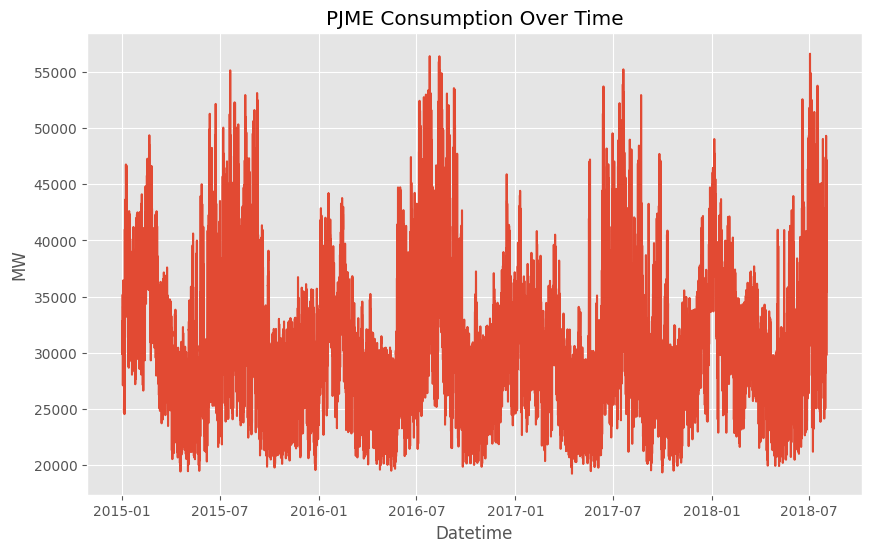

In [5]:
def plot_consumption(df):
    """Plot PJME consumption over time."""
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df.reset_index(), x='Datetime', y='PJME_MW')
    plt.title('PJME Consumption Over Time')
    plt.xlabel('Datetime')
    plt.ylabel('MW')
    plt.grid(True)
    plt.show()

plot_consumption(df_PJME)

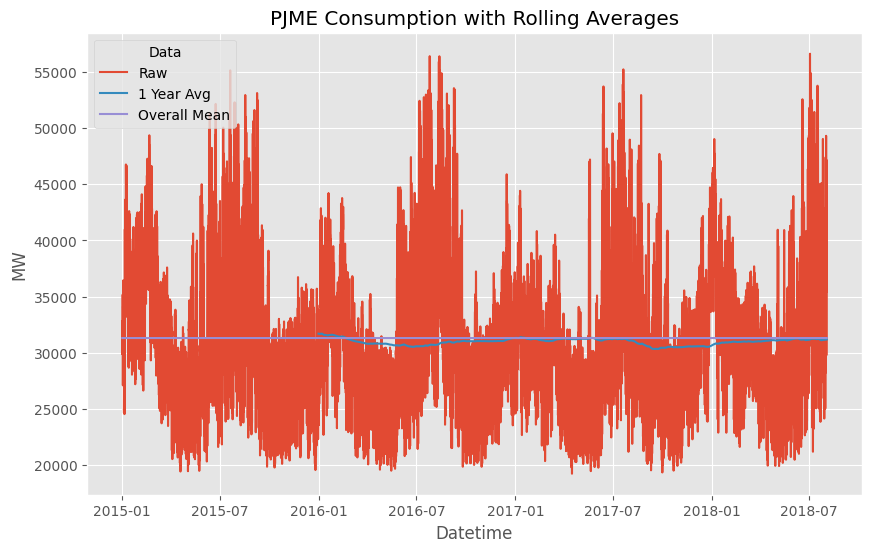

In [6]:
# Calculate rolling statistics
df_PJME[f'PJME_MW_Avg{1}y'] = df_PJME['PJME_MW'].rolling(24*365*1).mean()
df_PJME['PJME_MW_Mean'] = df_PJME['PJME_MW'].mean()

# Plot rolling statistics
def plot_rolling_stats(df):
    """Plot PJME consumption with rolling averages."""
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df.reset_index(), x='Datetime', y='PJME_MW', label="Raw")
    sns.lineplot(data=df.reset_index(), x='Datetime', y=f'PJME_MW_Avg{1}y', label="1 Year Avg")
    sns.lineplot(data=df.reset_index(), x='Datetime', y=f'PJME_MW_Mean', label="Overall Mean")
    plt.title('PJME Consumption with Rolling Averages')
    plt.xlabel('Datetime')
    plt.ylabel('MW')
    plt.legend(title='Data', loc='upper left', fontsize=10)
    plt.grid(True)
    plt.show()

plot_rolling_stats(df_PJME)

In [7]:
# Perform Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(df_PJME['PJME_MW'])
test_statistic, p_value, _, _, _, _ = adf_result
print(f'ADF Statistic: {test_statistic:0.5f}')
print(f'P-value: {p_value:0.2f}')

ADF Statistic: -10.31427
P-value: 0.00


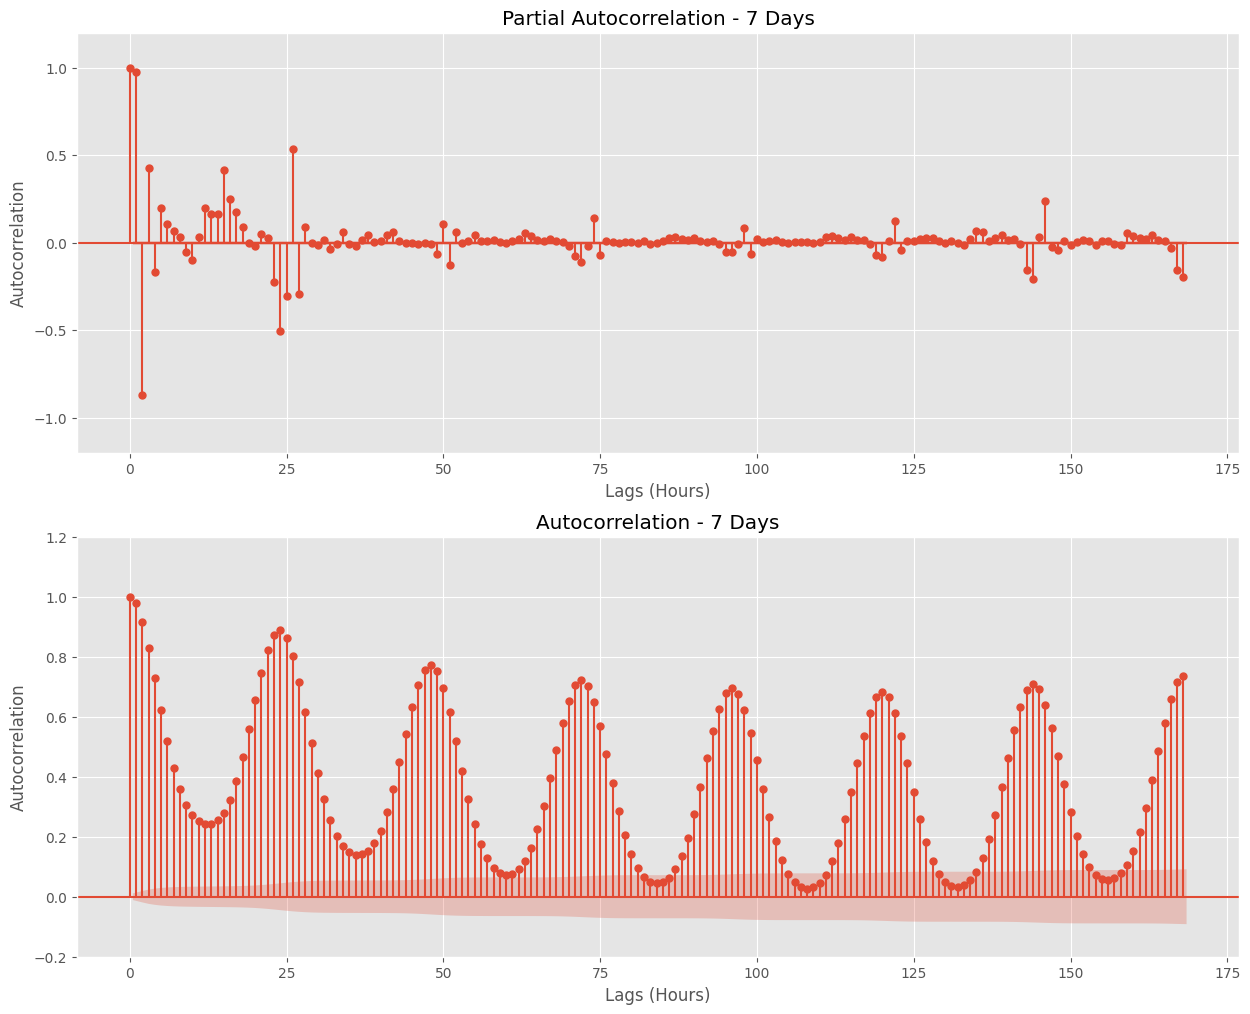

In [8]:
# Plot autocorrelation and partial autocorrelation
def plot_autocorrelation(df):
    """Plot autocorrelation and partial autocorrelation."""
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))
    plot_pacf(df['PJME_MW'], lags=24*7, ax=ax[0])
    ax[0].set_title('Partial Autocorrelation - 7 Days')
    ax[0].set_xlabel('Lags (Hours)')
    ax[0].set_ylabel('Autocorrelation')
    ax[0].set_ylim(-1.2, 1.2)
    ax[0].grid(True)

    plot_acf(df['PJME_MW'], lags=24*7, ax=ax[1])
    ax[1].set_title('Autocorrelation - 7 Days')
    ax[1].set_xlabel('Lags (Hours)')
    ax[1].set_ylabel('Autocorrelation')
    ax[1].set_ylim(-0.2, 1.2)
    ax[1].grid(True)
    plt.show()

plot_autocorrelation(df_PJME)

In [15]:
# Split data into training and test sets
df_training = df_PJME[df_PJME['Year'] <= 2016]['PJME_MW']
df_test = df_PJME[df_PJME['Year'] >= 2017]['PJME_MW']

df_training.index = pd.to_datetime(df_training.index)
df_test.index = pd.to_datetime(df_test.index)

df_training = df_training.to_frame()
df_test = df_test.to_frame()

# Add Year, Month, Hour, Day of Year to training and test sets
df_training['Year'] = df_training.index.year
df_training['Month'] = df_training.index.month
df_training['Hour'] = df_training.index.hour
df_training['Day_of_Year'] = df_training.index.dayofyear

df_test['Year'] = df_test.index.year
df_test['Month'] = df_test.index.month
df_test['Hour'] = df_test.index.hour
df_test['Day_of_Year'] = df_test.index.dayofyear

# Print data descriptions
print("Training:")
print(df_training.reset_index().describe())
print("\n")
print("Test:")
print(df_test.reset_index().describe())


Training:
                  Datetime       PJME_MW          Year         Month  \
count                17544  17544.000000  17544.000000  17544.000000   
mean   2016-01-01 11:30:00  31523.755757   2015.500684      6.519836   
min    2015-01-01 00:00:00  19450.000000   2015.000000      1.000000   
25%    2015-07-02 17:45:00  26821.250000   2015.000000      4.000000   
50%    2016-01-01 11:30:00  30233.000000   2016.000000      7.000000   
75%    2016-07-02 05:15:00  35524.250000   2016.000000     10.000000   
max    2016-12-31 23:00:00  56391.000000   2016.000000     12.000000   
std                    NaN   6689.189631      0.500014      3.449649   

               Hour   Day_of_Year  
count  17544.000000  17544.000000  
mean      11.500000    183.250342  
min        0.000000      1.000000  
25%        5.750000     92.000000  
50%       11.500000    183.000000  
75%       17.250000    275.000000  
max       23.000000    366.000000  
std        6.922384    105.513966  


Test:
         

In [18]:
from statsmodels.tsa.arima.model import ARIMA

p = 3
d = 0
q = 6

model_arima = ARIMA(df_training['PJME_MW'], order=(p,d,q))
model_arima = model_arima.fit()
print(model_arima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                PJME_MW   No. Observations:                17544
Model:                 ARIMA(3, 0, 6)   Log Likelihood             -136712.793
Date:                Sat, 05 Apr 2025   AIC                         273447.586
Time:                        22:02:50   BIC                         273533.083
Sample:                    01-01-2015   HQIC                        273475.736
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.152e+04    215.805    146.075      0.000    3.11e+04    3.19e+04
ar.L1          0.5998      0.010     59.137      0.000       0.580       0.620
ar.L2          0.9236      0.003    337.261      0.0

In [19]:
# Extract parameters as a dictionary
params_dict = model_arima.params.to_dict()

# Save to JSON
import json
with open('arima_parameters.json', 'w') as f:
    json.dump(params_dict, f, indent=4)


In [20]:
df_training_arima_pred = model_arima.predict()
df_training_arima_pred = df_training_arima_pred.to_frame()

# Get Year
df_training_arima_pred['Year'] = df_training_arima_pred.index.year
df_training_arima_pred['Month'] = df_training_arima_pred.index.month

print("Training Predictions:")
print(df_training_arima_pred)

Training Predictions:
                     predicted_mean  Year  Month
Datetime                                        
2015-01-01 00:00:00    31523.755746  2015      1
2015-01-01 01:00:00    32773.192505  2015      1
2015-01-01 02:00:00    30625.360245  2015      1
2015-01-01 03:00:00    30124.432191  2015      1
2015-01-01 04:00:00    29785.606332  2015      1
...                             ...   ...    ...
2016-12-31 19:00:00    36534.558904  2016     12
2016-12-31 20:00:00    33295.532433  2016     12
2016-12-31 21:00:00    32551.638157  2016     12
2016-12-31 22:00:00    31200.924600  2016     12
2016-12-31 23:00:00    29105.790307  2016     12

[17544 rows x 3 columns]


In [21]:
df_test_arima_pred = model_arima.predict(df_test.index.min(), df_test.index.max())
df_test_arima_pred = df_test_arima_pred.to_frame()

df_test_arima_pred.index = df_test_arima_pred.index.rename("Datetime")

# Get Year
df_test_arima_pred['Year'] = df_test_arima_pred.index.year
df_test_arima_pred['Month'] = df_test_arima_pred.index.month
df_test_arima_pred['Hour'] = df_test_arima_pred.index.hour

print("Test Predictions:")
print(df_test_arima_pred)

Test Predictions:
                     predicted_mean  Year  Month  Hour
Datetime                                              
2017-01-01 00:00:00    28229.068939  2017      1     0
2017-01-01 01:00:00    27404.879264  2017      1     1
2017-01-01 02:00:00    27078.759086  2017      1     2
2017-01-01 03:00:00    27140.023316  2017      1     3
2017-01-01 04:00:00    27712.407003  2017      1     4
...                             ...   ...    ...   ...
2018-08-02 20:00:00    31523.755746  2018      8    20
2018-08-02 21:00:00    31523.755746  2018      8    21
2018-08-02 22:00:00    31523.755746  2018      8    22
2018-08-02 23:00:00    31523.755746  2018      8    23
2018-08-03 00:00:00    31523.755746  2018      8     0

[13897 rows x 4 columns]


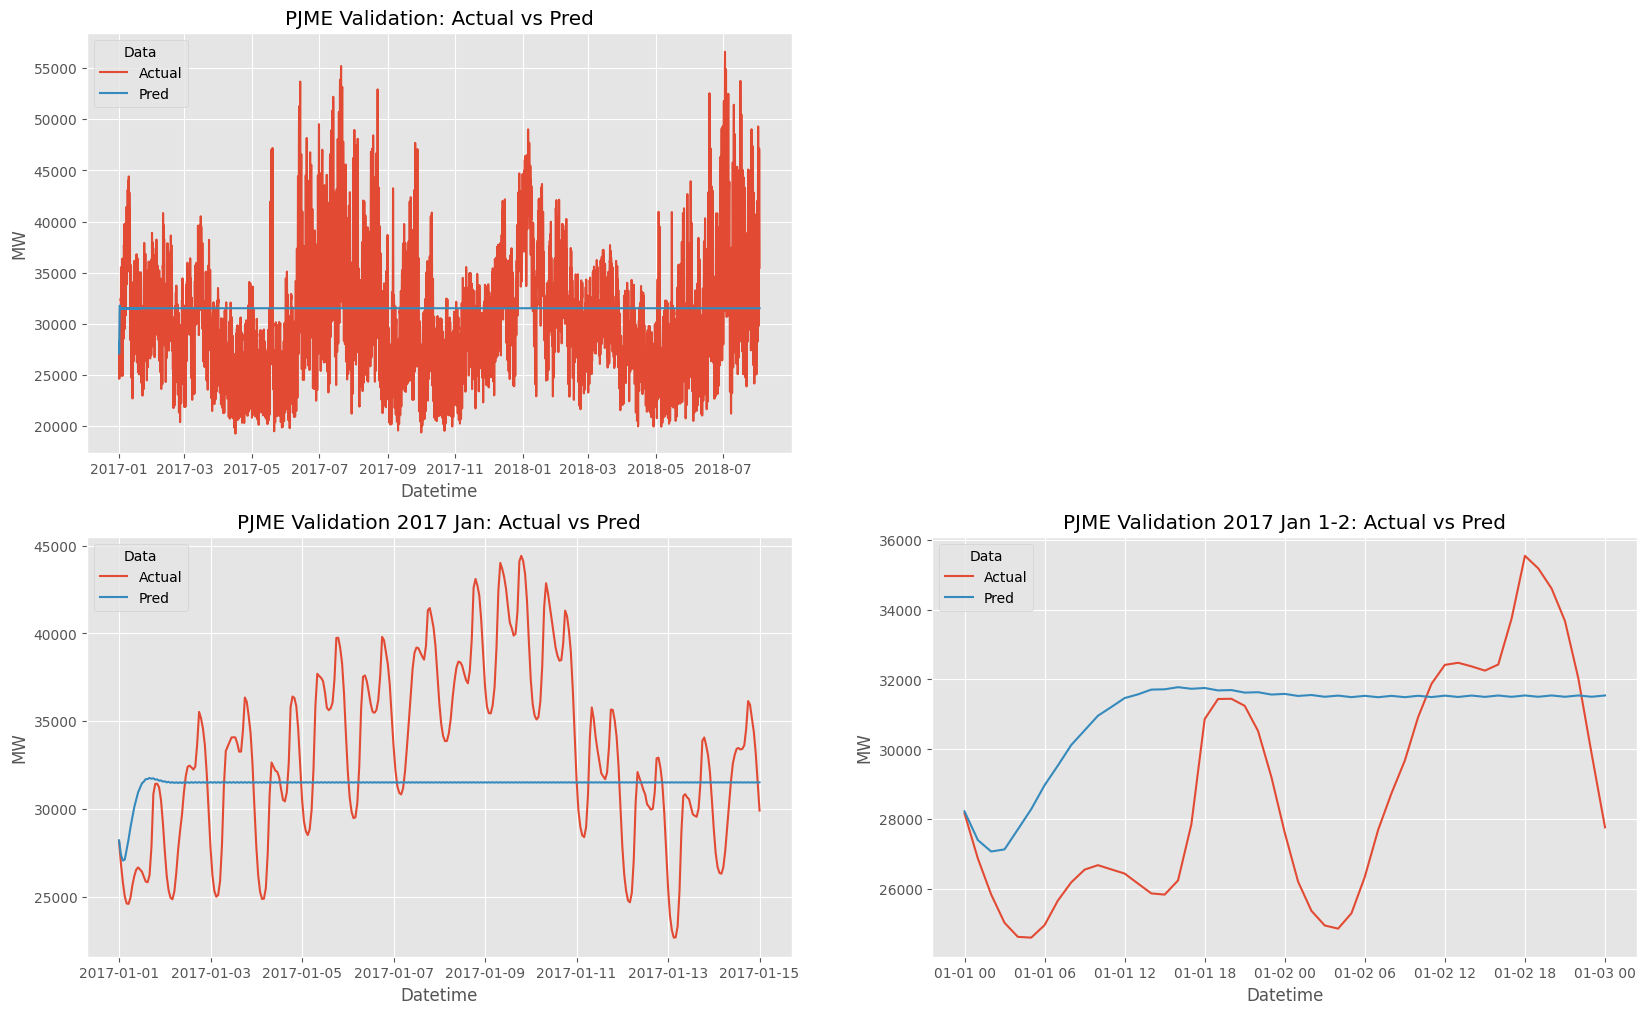

In [22]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)

sns.lineplot(data=df_test.reset_index(), x='Datetime', y='PJME_MW', label ="Actual")
sns.lineplot(data=df_test_arima_pred.reset_index(), x='Datetime', y='predicted_mean', label="Pred")

plt.title('PJME Validation: Actual vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)

plt.subplot(2,2,3)

sns.lineplot(data=df_test.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-15 00:00:00')].reset_index(), x='Datetime', y='PJME_MW', label ="Actual")
sns.lineplot(data=df_test_arima_pred.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-15 00:00:00')].reset_index(), x='Datetime', y='predicted_mean', label="Pred")

plt.title('PJME Validation 2017 Jan: Actual vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)

plt.subplot(2,2,4)

sns.lineplot(data=df_test.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-03 00:00:00')].reset_index(), x='Datetime', y='PJME_MW', label ="Actual")
sns.lineplot(data=df_test_arima_pred.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-03 00:00:00')].reset_index(), x='Datetime', y='predicted_mean', label="Pred")

plt.title('PJME Validation 2017 Jan 1-2: Actual vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)


In [24]:
print("ARIMA - RESULTS\n")

rmse_full = np.sqrt(mean_squared_error(df_test['PJME_MW'], df_test_arima_pred['predicted_mean']))
#rmse_full = root_mean_squared_error(df_test['PJME_MW'], df_test_arima_pred['predicted_mean'])
print(f"RMSE Overall: {rmse_full}")
print("\n")

# RMSE for each Month
for month in range(1,13):
  try:
    rmse = np.sqrt(mean_squared_error(df_test[df_test['Month'] == month]['PJME_MW'], df_test_arima_pred[df_test_arima_pred['Month'] == month]['predicted_mean']))
    #rmse = root_mean_squared_error(df_test[df_test['Month'] == month]['PJME_MW'], df_test_arima_pred[df_test_arima_pred['Month'] == month]['predicted_mean'])
    print(f"RMSE (month: {month}): {rmse}")
  except:
    pass
print("\n")

# RMSE for each Hour
for hour in range(0,24):
  try:
    rmse = np.sqrt(mean_squared_error(df_test[df_test['Hour'] == hour]['PJME_MW'], df_test_arima_pred[df_test_arima_pred['Hour'] == hour]['predicted_mean']))
    #rmse = root_mean_squared_error(df_test[df_test['Hour'] == hour]['PJME_MW'], df_test_arima_pred[df_test_arima_pred['Hour'] == hour]['predicted_mean'])
    print(f"RMSE (hour: {hour}): {rmse}")
  except:
    pass
print("\n")

ARIMA - RESULTS

RMSE Overall: 6139.0483996154135


RMSE (month: 1): 5748.442806328334
RMSE (month: 2): 4126.7781732792255
RMSE (month: 3): 3698.10746594054
RMSE (month: 4): 5738.031156860629
RMSE (month: 5): 6263.2084885408985
RMSE (month: 6): 7087.8664268564635
RMSE (month: 7): 9143.606955058849
RMSE (month: 8): 7282.67389738729
RMSE (month: 9): 6329.265782587223
RMSE (month: 10): 6052.182261036927
RMSE (month: 11): 4363.964899748108
RMSE (month: 12): 4772.265720844091


RMSE (hour: 0): 5016.533558032975
RMSE (hour: 1): 5984.187883431149
RMSE (hour: 2): 6755.9097741737505
RMSE (hour: 3): 7229.400580317743
RMSE (hour: 4): 7416.829216379832
RMSE (hour: 5): 7136.754567878205
RMSE (hour: 6): 6186.72943099756
RMSE (hour: 7): 5197.4352011820365
RMSE (hour: 8): 4812.309539664474
RMSE (hour: 9): 4482.177583660473
RMSE (hour: 10): 4466.4325900861295
RMSE (hour: 11): 4827.837053497989
RMSE (hour: 12): 5340.751298851506
RMSE (hour: 13): 5855.794088968931
RMSE (hour: 14): 6366.28328149905
RMSE (

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 0
d = 0
q = 0

P = 2
D = 1
Q = 1
S = 24

model_sarima = SARIMAX(df_training['PJME_MW'], order=(p,q,d), seasonal_order=(P,D,Q,S))
model_sarima = model_sarima.fit(low_memory=True)
print(model_sarima.summary())

                                 SARIMAX Results                                  
Dep. Variable:                    PJME_MW   No. Observations:                17544
Model:             SARIMAX(2, 1, [1], 24)   Log Likelihood             -163496.423
Date:                    Sat, 05 Apr 2025   AIC                         327000.846
Time:                            22:12:23   BIC                         327031.931
Sample:                        01-01-2015   HQIC                        327011.082
                             - 12-31-2016                                         
Covariance Type:                   approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.7405      0.010     75.574      0.000       0.721       0.760
ar.S.L48      -0.2459      0.008    -32.183      0.000      -0.261      -0.231
ma.S.L24      -0.830

In [26]:
df_training_sarima_pred = model_sarima.predict()
df_training_sarima_pred = df_training_sarima_pred.to_frame()

# Get Year
df_training_sarima_pred['Year'] = df_training_sarima_pred.index.year
df_training_sarima_pred['Month'] = df_training_sarima_pred.index.month
df_training_sarima_pred['Hour'] = df_training_sarima_pred.index.hour

print("Training Predictions:")
print(df_training_sarima_pred)

Training Predictions:
                     predicted_mean  Year  Month  Hour
Datetime                                              
2015-01-01 00:00:00    0.000000e+00  2015      1     0
2015-01-01 01:00:00    7.321962e-11  2015      1     1
2015-01-01 02:00:00    9.399474e-11  2015      1     2
2015-01-01 03:00:00    6.264418e-11  2015      1     3
2015-01-01 04:00:00    2.426933e-11  2015      1     4
...                             ...   ...    ...   ...
2016-12-31 19:00:00    3.653623e+04  2016     12    19
2016-12-31 20:00:00    3.602163e+04  2016     12    20
2016-12-31 21:00:00    3.538716e+04  2016     12    21
2016-12-31 22:00:00    3.432560e+04  2016     12    22
2016-12-31 23:00:00    3.269759e+04  2016     12    23

[17544 rows x 4 columns]


In [27]:
df_test_sarima_pred = model_sarima.predict(df_test.index.min(), df_test.index.max())
df_test_sarima_pred = df_test_sarima_pred.to_frame()

df_test_sarima_pred.index = df_test_sarima_pred.index.rename("Datetime")

# Get Year
df_test_sarima_pred['Year'] = df_test_sarima_pred.index.year
df_test_sarima_pred['Month'] = df_test_sarima_pred.index.month
df_test_sarima_pred['Hour'] = df_test_sarima_pred.index.hour

print("Test Predictions:")
print(df_test_sarima_pred)


Test Predictions:
                     predicted_mean  Year  Month  Hour
Datetime                                              
2017-01-01 00:00:00    30904.122066  2017      1     0
2017-01-01 01:00:00    29361.071221  2017      1     1
2017-01-01 02:00:00    28476.002171  2017      1     2
2017-01-01 03:00:00    27993.203796  2017      1     3
2017-01-01 04:00:00    27883.474684  2017      1     4
...                             ...   ...    ...   ...
2018-08-02 20:00:00    34539.479667  2018      8    20
2018-08-02 21:00:00    33774.714870  2018      8    21
2018-08-02 22:00:00    32589.474130  2018      8    22
2018-08-02 23:00:00    30932.735174  2018      8    23
2018-08-03 00:00:00    30087.268680  2018      8     0

[13897 rows x 4 columns]


In [28]:
# Extract SARIMA model parameters as a dictionary
sarima_params_dict = model_sarima.params.to_dict()

# Save to JSON
import json
with open('sarima_parameters.json', 'w') as f:
    json.dump(sarima_params_dict, f, indent=4)


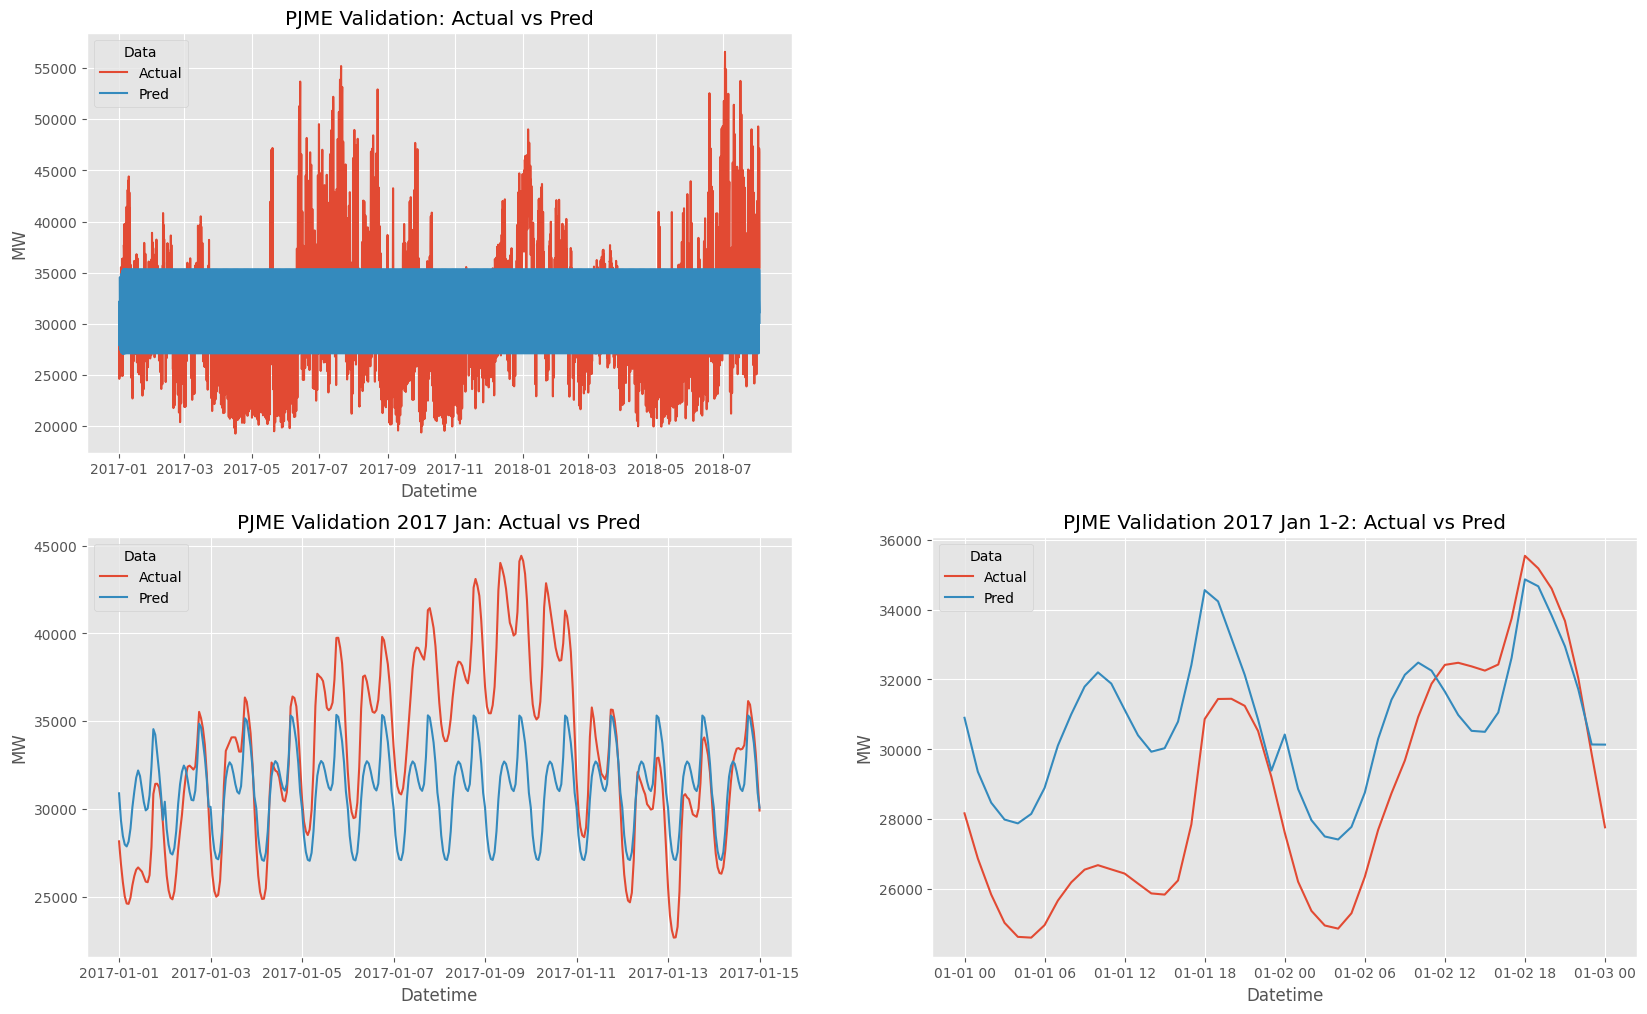

In [29]:
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)

sns.lineplot(data=df_test.reset_index(), x='Datetime', y='PJME_MW', label ="Actual")
sns.lineplot(data=df_test_sarima_pred.reset_index(), x='Datetime', y='predicted_mean', label="Pred")

plt.title('PJME Validation: Actual vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)

plt.subplot(2,2,3)

sns.lineplot(data=df_test.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-15 00:00:00')].reset_index(), x='Datetime', y='PJME_MW', label ="Actual")
sns.lineplot(data=df_test_sarima_pred.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-15 00:00:00')].reset_index(), x='Datetime', y='predicted_mean', label="Pred")

plt.title('PJME Validation 2017 Jan: Actual vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)

plt.subplot(2,2,4)

sns.lineplot(data=df_test.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-03 00:00:00')].reset_index(), x='Datetime', y='PJME_MW', label ="Actual")
sns.lineplot(data=df_test_sarima_pred.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-03 00:00:00')].reset_index(), x='Datetime', y='predicted_mean', label="Pred")

plt.title('PJME Validation 2017 Jan 1-2: Actual vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)

In [36]:
print("SARIMA - RESULTS\n")

rmse_full = np.sqrt(mean_squared_error(df_test['PJME_MW'], df_test_sarima_pred['predicted_mean']))
#rmse_full = root_mean_squared_error(df_test['PJME_MW'], df_test_sarima_pred['predicted_mean'])
print(f"RMSE Overall: {rmse_full}")
print("\n")

# RMSE for each Month
for month in range(1,13):
  try:
    rmse = np.sqrt(mean_squared_error(df_test[df_test['Month'] == month]['PJME_MW'], df_test_sarima_pred[df_test_sarima_pred['Month'] == month]['predicted_mean']))
    #rmse = root_mean_squared_error(df_test[df_test['Month'] == month]['PJME_MW'], df_test_sarima_pred[df_test_sarima_pred['Month'] == month]['predicted_mean'])
    print(f"RMSE (month: {month}): {rmse}")
  except:
    pass
print("\n")

# RMSE for each Hour
for hour in range(0,24):
  try:
    rmse = np.sqrt(mean_squared_error(df_test[df_test['Hour'] == hour]['PJME_MW'], df_test_sarima_pred[df_test_sarima_pred['Hour'] == hour]['predicted_mean']))
    #rmse = root_mean_squared_error(df_test[df_test['Hour'] == hour]['PJME_MW'], df_test_sarima_pred[df_test_sarima_pred['Hour'] == hour]['predicted_mean'])
    print(f"RMSE (hour: {hour}): {rmse}")
  except:
    pass
print("\n")

SARIMA - RESULTS

RMSE Overall: 5302.205678588643


RMSE (month: 1): 5274.586021859688
RMSE (month: 2): 3319.4672509927323
RMSE (month: 3): 3064.415731111487
RMSE (month: 4): 5043.091686670182
RMSE (month: 5): 5268.603575127467
RMSE (month: 6): 5980.419883236656
RMSE (month: 7): 8292.27361007005
RMSE (month: 8): 6223.408589824771
RMSE (month: 9): 5170.286729694321
RMSE (month: 10): 5050.693483639935
RMSE (month: 11): 3323.2403044325306
RMSE (month: 12): 3994.7435764883885


RMSE (hour: 0): 4413.864314255853
RMSE (hour: 1): 4245.547150133231
RMSE (hour: 2): 4193.9976824474115
RMSE (hour: 3): 4210.464185125064
RMSE (hour: 4): 4287.18740172691
RMSE (hour: 5): 4387.082141464903
RMSE (hour: 6): 4508.710885569402
RMSE (hour: 7): 4826.039592715554
RMSE (hour: 8): 4878.376668658267
RMSE (hour: 9): 4571.9782453253265
RMSE (hour: 10): 4473.917126727432
RMSE (hour: 11): 4717.267596410167
RMSE (hour: 12): 5222.448186346441
RMSE (hour: 13): 5839.911023349453
RMSE (hour: 14): 6470.3267666586535
RMSE

In [30]:
p = 0
d = 0
q = 0

P = 2
D = 1
Q = 1
S = 24

model_sarimax = SARIMAX(df_training['PJME_MW'], exog=df_training[['Month', 'Day_of_Year']], order=(p,q,d), seasonal_order=(P,D,Q,S))
model_sarimax = model_sarimax.fit(low_memory=True)
print(model_sarimax.summary())

                                 SARIMAX Results                                  
Dep. Variable:                    PJME_MW   No. Observations:                17544
Model:             SARIMAX(2, 1, [1], 24)   Log Likelihood             -163477.297
Date:                    Sat, 05 Apr 2025   AIC                         326966.594
Time:                            22:29:51   BIC                         327013.220
Sample:                        01-01-2015   HQIC                        326981.947
                             - 12-31-2016                                         
Covariance Type:                   approx                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Month        -496.1501    118.551     -4.185      0.000    -728.505    -263.795
Day_of_Year     8.6734      3.887      2.231      0.026       1.055      16.292
ar.S.L24        

In [31]:
df_training_sarimax_pred = model_sarimax.predict()
df_training_sarimax_pred = df_training_sarimax_pred.to_frame()

# Get Year
df_training_sarimax_pred['Year'] = df_training_sarimax_pred.index.year
df_training_sarimax_pred['Month'] = df_training_sarimax_pred.index.month
df_training_sarimax_pred['Hour'] = df_training_sarimax_pred.index.hour

print("Training Predictions:")
print(df_training_sarimax_pred)

Training Predictions:
                     predicted_mean  Year  Month  Hour
Datetime                                              
2015-01-01 00:00:00     -487.476631  2015      1     0
2015-01-01 01:00:00     -487.476631  2015      1     1
2015-01-01 02:00:00     -487.476631  2015      1     2
2015-01-01 03:00:00     -487.476631  2015      1     3
2015-01-01 04:00:00     -487.476631  2015      1     4
...                             ...   ...    ...   ...
2016-12-31 19:00:00    36563.402050  2016     12    19
2016-12-31 20:00:00    36049.367553  2016     12    20
2016-12-31 21:00:00    35415.232172  2016     12    21
2016-12-31 22:00:00    34353.041392  2016     12    22
2016-12-31 23:00:00    32723.494411  2016     12    23

[17544 rows x 4 columns]


In [32]:
df_test_sarimax_pred = model_sarimax.predict(df_test.index.min(), df_test.index.max(), exog=df_test[['Month', 'Day_of_Year']] )
df_test_sarimax_pred = df_test_sarimax_pred.to_frame()

df_test_sarimax_pred.index = df_test_sarimax_pred.index.rename("Datetime")

# Get Year
df_test_sarimax_pred['Year'] = df_test_sarimax_pred.index.year
df_test_sarimax_pred['Month'] = df_test_sarimax_pred.index.month
df_test_sarimax_pred['Hour'] = df_test_sarimax_pred.index.hour

print("Test Predictions:")
print(df_test_sarimax_pred)

Test Predictions:
                     predicted_mean  Year  Month  Hour
Datetime                                              
2017-01-01 00:00:00    33211.769475  2017      1     0
2017-01-01 01:00:00    31668.246635  2017      1     1
2017-01-01 02:00:00    30783.015402  2017      1     2
2017-01-01 03:00:00    30300.521871  2017      1     3
2017-01-01 04:00:00    30191.293243  2017      1     4
...                             ...   ...    ...   ...
2018-08-02 20:00:00    35265.988078  2018      8    20
2018-08-02 21:00:00    34504.553247  2018      8    21
2018-08-02 22:00:00    33319.630790  2018      8    22
2018-08-02 23:00:00    31659.148496  2018      8    23
2018-08-03 00:00:00    30800.354188  2018      8     0

[13897 rows x 4 columns]


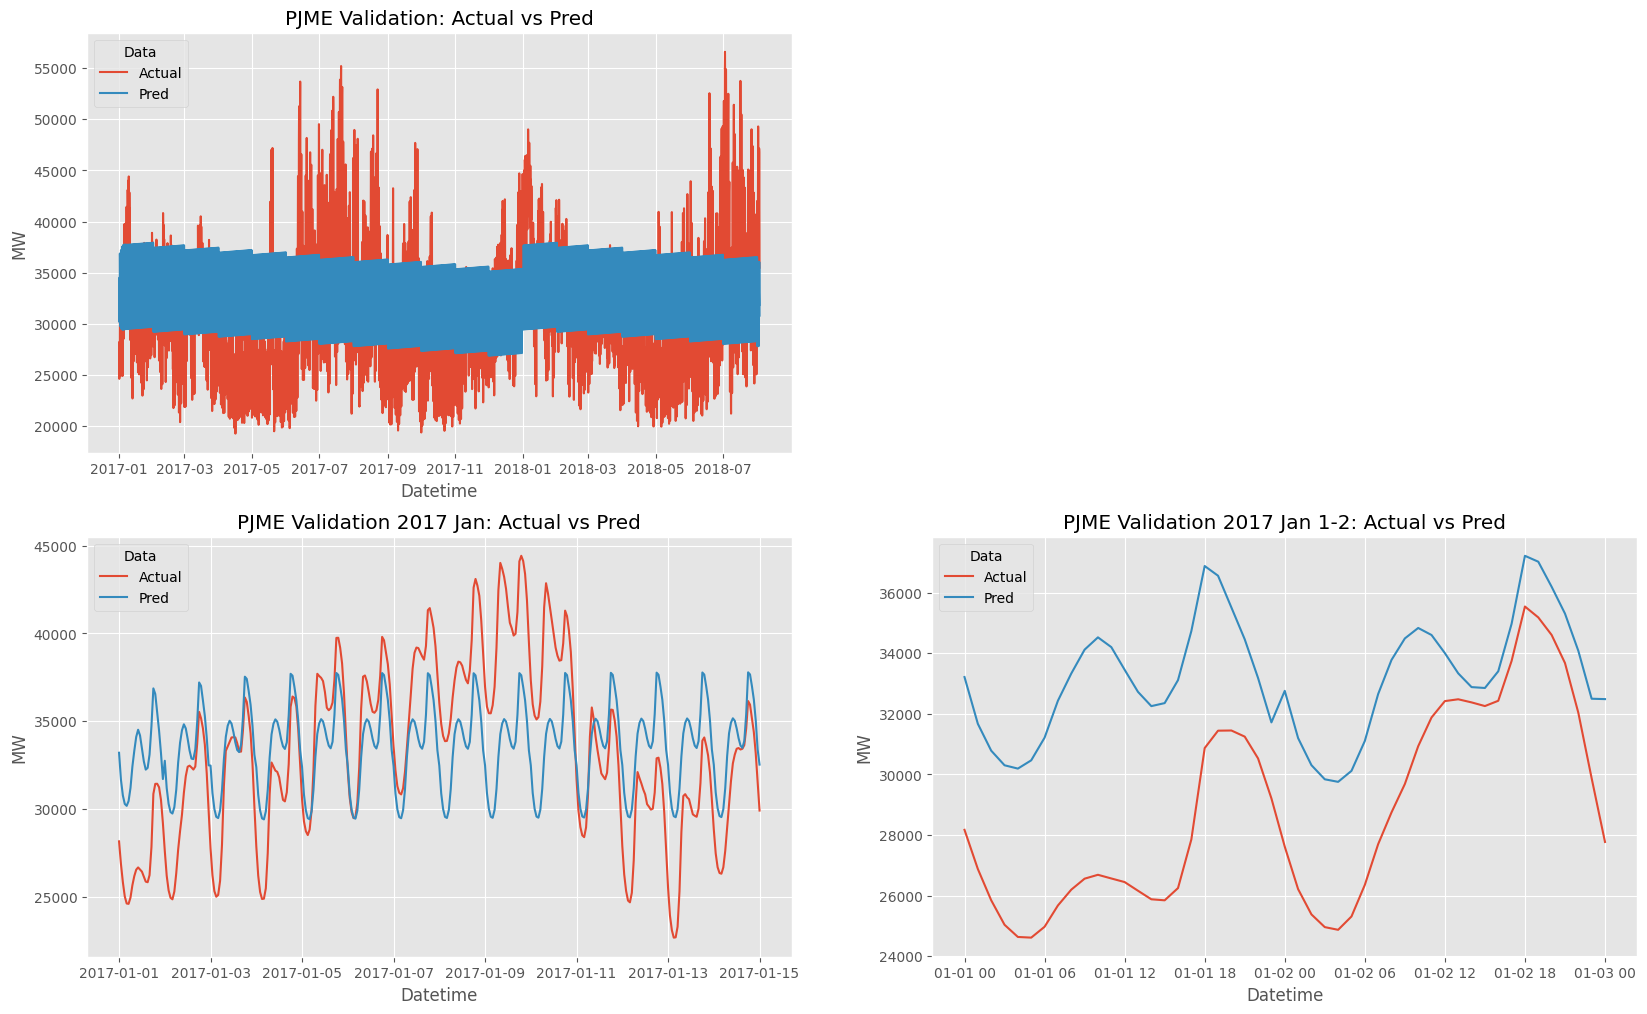

In [33]:
# Plots
plt.figure(figsize=(20,12))

plt.subplot(2,2,1)

sns.lineplot(data=df_test.reset_index(), x='Datetime', y='PJME_MW', label ="Actual")
sns.lineplot(data=df_test_sarimax_pred.reset_index(), x='Datetime', y='predicted_mean', label="Pred")

plt.title('PJME Validation: Actual vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)

plt.subplot(2,2,3)

sns.lineplot(data=df_test.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-15 00:00:00')].reset_index(), x='Datetime', y='PJME_MW', label ="Actual")
sns.lineplot(data=df_test_sarimax_pred.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-15 00:00:00')].reset_index(), x='Datetime', y='predicted_mean', label="Pred")

plt.title('PJME Validation 2017 Jan: Actual vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)

plt.subplot(2,2,4)

sns.lineplot(data=df_test.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-03 00:00:00')].reset_index(), x='Datetime', y='PJME_MW', label ="Actual")
sns.lineplot(data=df_test_sarimax_pred.loc[pd.to_datetime('2017-01-01 00:00:00'):pd.to_datetime('2017-01-03 00:00:00')].reset_index(), x='Datetime', y='predicted_mean', label="Pred")

plt.title('PJME Validation 2017 Jan 1-2: Actual vs Pred')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend(title='Data', loc='upper left', fontsize=10)
plt.grid(True)

In [34]:

print("SARIMAX - RESULTS\n")

rmse_full = np.sqrt(mean_squared_error(df_test['PJME_MW'], df_test_sarimax_pred['predicted_mean']))
#rmse_full = root_mean_squared_error(df_test['PJME_MW'], df_test_sarimax_pred['predicted_mean'])
print(f"RMSE Overall: {rmse_full}")
print("\n")

# RMSE for each Month
for month in range(1,13):
  try:
    rmse = np.sqrt(mean_squared_error(df_test[df_test['Month'] == month]['PJME_MW'], df_test_sarimax_pred[df_test_sarimax_pred['Month'] == month]['predicted_mean']))
    #rmse = root_mean_squared_error(df_test[df_test['Month'] == month]['PJME_MW'], df_test_sarimax_pred[df_test_sarimax_pred['Month'] == month]['predicted_mean'])
    print(f"RMSE (month: {month}): {rmse}")
  except:
    pass
print("\n")

# RMSE for each Hour
for hour in range(0,24):
  try:
    rmse = np.sqrt(mean_squared_error(df_test[df_test['Hour'] == hour]['PJME_MW'], df_test_sarimax_pred[df_test_sarimax_pred['Hour'] == hour]['predicted_mean']))
    #rmse = root_mean_squared_error(df_test[df_test['Hour'] == hour]['PJME_MW'], df_test_sarimax_pred[df_test_sarimax_pred['Hour'] == hour]['predicted_mean'])
    print(f"RMSE (hour: {hour}): {rmse}")
  except:
    pass
print("\n")

SARIMAX - RESULTS

RMSE Overall: 5575.924986668335


RMSE (month: 1): 4631.901491965747
RMSE (month: 2): 4298.937518308309
RMSE (month: 3): 4112.93603003042
RMSE (month: 4): 6641.789253727379
RMSE (month: 5): 6366.231232685188
RMSE (month: 6): 5828.200772365345
RMSE (month: 7): 7656.317857827784
RMSE (month: 8): 5946.570712893453
RMSE (month: 9): 5321.681309047422
RMSE (month: 10): 5363.16667910537
RMSE (month: 11): 3427.015830693924
RMSE (month: 12): 3995.7751302091874


RMSE (hour: 0): 5030.204291880972
RMSE (hour: 1): 4908.018611436789
RMSE (hour: 2): 4890.243861850025
RMSE (hour: 3): 4928.819753600028
RMSE (hour: 4): 5019.086830456183
RMSE (hour: 5): 5108.948042144465
RMSE (hour: 6): 5153.838859252622
RMSE (hour: 7): 5317.170542686403
RMSE (hour: 8): 5288.846669294628
RMSE (hour: 9): 4984.202211817442
RMSE (hour: 10): 4862.989220460965
RMSE (hour: 11): 4972.830337160199
RMSE (hour: 12): 5306.954290590162
RMSE (hour: 13): 5776.429971047395
RMSE (hour: 14): 6302.30939726164
RMSE (hou

In [35]:
se_full = np.sqrt(mean_squared_error(df_test['PJME_MW'], df_test_sarimax_pred['predicted_mean']))
#rmse_full = root_mean_squared_error(df_test['PJME_MW'], df_test_arima_pred['predicted_mean'])
print(f"RMSE Overall: {rmse_full}")
print("\n")

print("SARIMA")
rmse_full = np.sqrt(mean_squared_error(df_test['PJME_MW'], df_test_sarimax_pred['predicted_mean']))
#rmse_full = root_mean_squared_error(df_test['PJME_MW'], df_test_sarima_pred['predicted_mean'])
print(f"RMSE Overall: {rmse_full}")
print("\n")

print("SARIMAX")
rmse_full = np.sqrt(mean_squared_error(df_test['PJME_MW'], df_test_sarimax_pred['predicted_mean']))
#rmse_full = root_mean_squared_error(df_test['PJME_MW'], df_test_sarimax_pred['predicted_mean'])
print(f"RMSE Overall: {rmse_full}")
print("\n")

RMSE Overall: 5575.924986668335


SARIMA
RMSE Overall: 5575.924986668335


SARIMAX
RMSE Overall: 5575.924986668335


